In [16]:
import numpy as np

from dipy.data import fetch_cenir_multib
from dipy.data import read_cenir_multib
from dipy.segment.mask import median_otsu


import os, sys
%matplotlib inline
import matplotlib.pyplot as plt
module_path = os.path.join(os.path.abspath(os.path.join('..')), 'pymods')
if module_path not in sys.path:
    sys.path.append(module_path)
from plotutils import plot_3d_z_indices

In [2]:
# This downloads only eddy-current/motion corrected data 
fetch_cenir_multib(with_raw=False)

Creating new folder /home/sld0465/.dipy/cenir_multib
Download Progress: [##################################] 100.00%  of 53.31 MBDownloading "dwi_bvals_B200" to /home/sld0465/.dipy/cenir_multib
Download Progress: [##################################] 100.00%  of 0.00 MBDownloading "dwi_bvecs_B200" to /home/sld0465/.dipy/cenir_multib
Download Progress: [##################################] 100.00%  of 0.00 MBDownloading "4D_dwieddycor_B400.nii.gz" to /home/sld0465/.dipy/cenir_multib
Download Progress: [##################################] 100.00%  of 53.20 MBDownloading "bvals_B400" to /home/sld0465/.dipy/cenir_multib
Download Progress: [##################################] 100.00%  of 0.00 MBDownloading "bvecs_B400" to /home/sld0465/.dipy/cenir_multib
Download Progress: [##################################] 100.00%  of 0.00 MBDownloading "4D_dwieddycor_B1000.nii.gz" to /home/sld0465/.dipy/cenir_multib
Download Progress: [##################################] 100.00%  of 534.97 MBDownloading "

({'4D_dwi_eddycor_B200.nii.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33311/4D_dwi_eddycor_B200.nii.gz',
   'fd704aa3deb83c1c7229202cb3db8c48'),
  '4D_dwieddycor_B1000.nii.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33311/4D_dwieddycor_B1000.nii.gz',
   'dde8037601a14436b2173f4345b5fd17'),
  '4D_dwieddycor_B2000.nii.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33311/4D_dwieddycor_B2000.nii.gz',
   'c5e4b96e3afdee99c0e994eff3b2331a'),
  '4D_dwieddycor_B3000.nii.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33311/4D_dwieddycor_B3000.nii.gz',
   'f0d70456ce424fda2cecd48e64f3a151'),
  '4D_dwieddycor_B400.nii.gz': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33311/4D_dwieddycor_B400.nii.gz',
   '3d0f2b8ef7b6a4a3aa5c4f7a90c9cfec'),
  'bvals_B1000': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33311/bvals_

In [3]:
# Read just one shell of data for b-value = 1000
img, gtab = read_cenir_multib([1000])
data = img.get_data()

Dataset is already in place. If you want to fetch it again please first remove the folder /home/sld0465/.dipy/cenir_multib 


In [5]:
data.shape

(104, 104, 72, 202)

In [17]:
#we remove the background of the image to avoid unnecessary calculations.
maskdata, mask = median_otsu(data, 4, 2, False, vol_idx=[0], dilate=1)

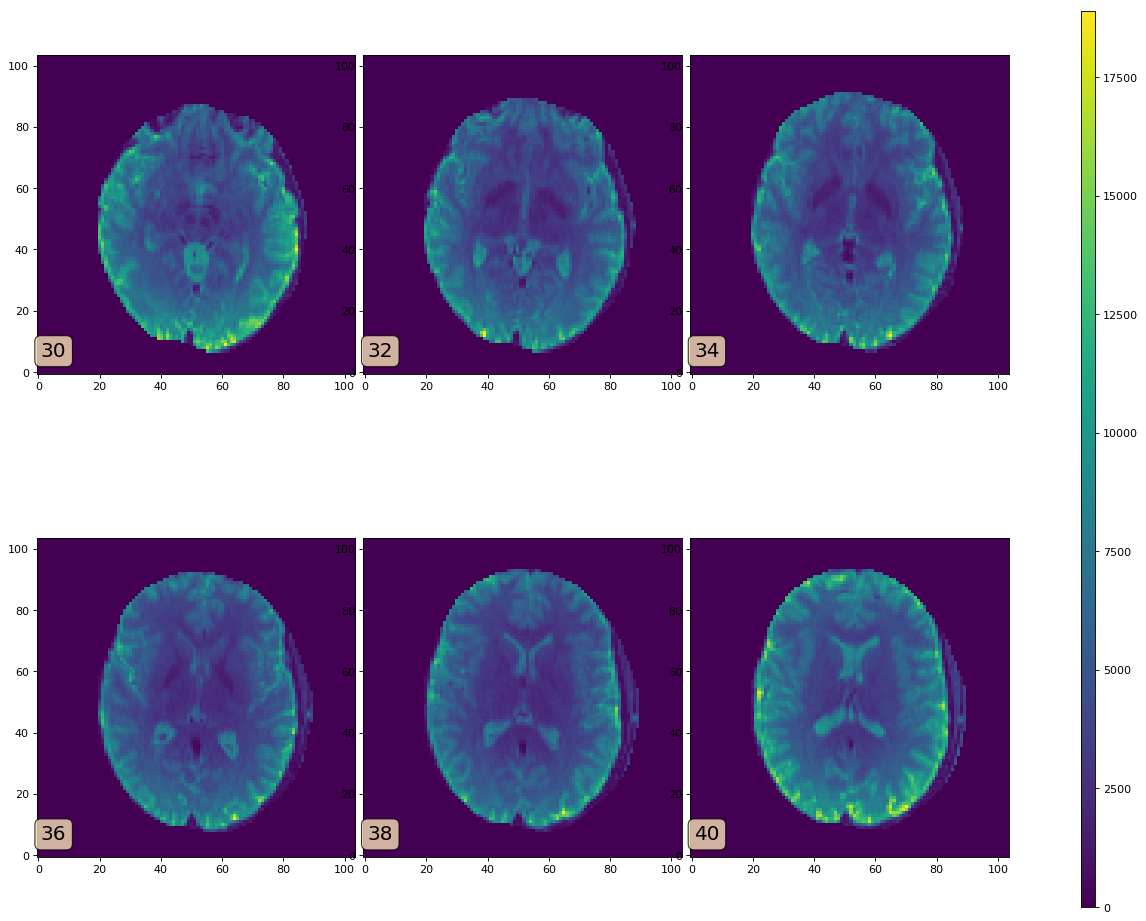

In [20]:
plot_3d_z_indices(maskdata[:,:,:,0], idx_list=range(30, 41, 2) , num_rows=2, num_cols=3)

In [23]:
smalldata = maskdata[:,:,30:41, :]
smalldata.shape

(104, 104, 11, 202)